**Google Drive Linki:**
https://drive.google.com/drive/folders/1lsFD4Aw-vhoVQNH0WNzFX8fhVr-yrM9O?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import cv2
import os,glob
from os import listdir,makedirs
from os.path import isfile,join
!pip install split_folders

In [7]:
resim_boyut = 50


def gray_resize(yol, hedef_yol):
    try:
        makedirs(hedef_yol)
    except:
        print("Dosya yolu zaten var, resimler aynı dosyaya kaydedilecek.")

    files = [f for f in listdir(yol) if isfile(join(yol, f))]
    for resim_to in files:
        try:
            resim = cv2.imread(os.path.join(yol, resim_to))
            gray_resim = cv2.cvtColor(resim, cv2.COLOR_BGR2GRAY)
            kaynak_yol = join(hedef_yol, resim_to)
            cv2.imwrite(kaynak_yol, gray_resim)
        except:
            print("{} dosyası çevrilemedi.".format(resim_to))
    for fil in glob.glob("*.jpg"):
        try:
            resim_to = cv2.imread(fil)
            gray_resim2 = cv2.cvtColor(resim_to, cv2.COLOR_BGR2GRAY)  # convert to greyscale
            yeni_boyut = cv2.resize(gray_resim2, (resim_boyut, resim_boyut))
            cv2.imwrite(os.path.join(hedef_yol, fil), yeni_boyut)
        except:
            print('{} dosyası çevrilemedi.')


keyboard = r"/content/gdrive/My Drive/Colab Notebooks/images/keyboard"  # kaynak klasor
kaynak_keyboard = r"/content/gdrive/My Drive/Colab Notebooks/gray_scalling/keyboard"  # hedef klasor
os.mkdir(kaynak_keyboard)
mouse = r"/content/gdrive/My Drive/Colab Notebooks/images/mouse"  # kaynak klasor
kaynak_mouse = r"/content/gdrive/My Drive/Colab Notebooks/gray_scalling/mouse"  # hedef klasor
os.mkdir(kaynak_mouse)

gray_resize(keyboard, kaynak_keyboard)
gray_resize(mouse, kaynak_mouse)

Dosya yolu zaten var, resimler aynı dosyaya kaydedilecek.
Dosya yolu zaten var, resimler aynı dosyaya kaydedilecek.


In [8]:
import split_folders
split_folders.ratio(r"/content/gdrive/My Drive/Colab Notebooks/gray_scalling", output=r"/content/gdrive/My Drive/Colab Notebooks/resim_train_test_vali", seed=1337, ratio=(.8, .1, .1))

Copying files: 418 files [00:07, 58.32 files/s]


In [11]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

1. ADIM Normal olarak CNN-maxpool olayı sürecinde 20 epoch ile eğitime başlıyoruz.

In [12]:
from keras import layers, models, optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Using TensorFlow backend.


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_kısmı = r"/content/gdrive/My Drive/Colab Notebooks/resim_train_test_vali/train"
validation_kısmı = r"/content/gdrive/My Drive/Colab Notebooks/resim_train_test_vali/val"
# Piksel değerlerini [0, 1] ile [0, 50] arasında yeniden ölçeklendirir
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_kısmı,
    target_size=(50, 50), # train resimleri(50px x 50px)
    batch_size=50,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_kısmı,
    target_size=(50, 50), # validation resimleri(50px x 50px)
    batch_size=50,
    class_mode='binary')

Found 334 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=320,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=90)

Epoch 1/20
 28/320 [=>............................] - ETA: 1:32 - loss: 0.6682 - acc: 0.6826

In [ ]:
plot_accuracy_and_loss(history)

**Grafiğimize baktığımız zaman modelin overfit olduğunu görmüş bulunmaktayız. Bunun en büyük nedenlerinden biri eğitim verilerimizin sayısının az olmasından kaynaklanıyor. Diğer bir nedeni ise "test acc" değerimizin yüksek çıkmasıdır.**

In [ ]:
test_kısmı=r"/content/gdrive/My Drive/Colab Notebooks/resim_train_test_vali/test"
test_generator = test_datagen.flow_from_directory(
    test_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=90)
print('test acc:', test_acc)

2. ADIM Data augmentation yöntemi ile deneyi tekrarlamak



In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
mouse_train=r"/content/gdrive/My Drive/Colab Notebooks/resim_train_test_vali/train/mouse"
from keras.preprocessing import image

dosya_adi = [os.path.join(mouse_train, dosya) for dosya in os.listdir(mouse_train)]

img_path = dosya_adi[2] # resim secimi

img = image.load_img(img_path, target_size=(50, 50)) # resim boyutlandirilmasi

x = image.img_to_array(img) # Numpy array i (50, 50, 3) sekline donusturuyoruz

x = x.reshape((1,) + x.shape)

# resim gruplandirilmasi
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 2 == 0:
        break
plt.show()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

Found 334 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=960,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=90)

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
test_kısmı=r"/content/gdrive/My Drive/Colab Notebooks/resim_train_test_vali/test"
test_generator = test_datagen.flow_from_directory(
    test_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=90)
print('test acc:', test_acc)

Found 44 images belonging to 2 classes.
test acc: 0.9545454382896423


**Eğitimin Yorumu**

> Data Augmentationun amacı eldeki verilerin az olduğu zaman verileri çoğaltarak doğruluk payı yüksek bir başarı sağlamaktır. Grafiklerimize baktığımız zaman yine aynı sonucu almaktayız. Accuarcy grafiğimize baktığımızda ise acc değerimizin yine yüksek olduğunu gördük. Normal şartlar altında acc değerimizi grafiğe göre yorumlarsak overfit olduğu için yüksek çıkması normaldir. Machine Learning modellerinde accuarcy değerini 1.0 olarak yakalamak neredeyse imkansızdır. Bu yüzden accuarcy değerlerimizi 1.0 değerine yaklaştırmayı hedeflemeliyiz.


3. ADIM Drop-out ile deneyi tekrarlıyoruz.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # Dropout' u ekledik.
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

Found 334 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=960,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=90)

Epoch 1/20
960/960 [==============================] - 162s 169ms/step - loss: 0.4205 - acc: 0.8119 - val_loss: 0.5279 - val_acc: 0.8750
Epoch 2/20
960/960 [==============================] - 165s 172ms/step - loss: 0.2752 - acc: 0.8970 - val_loss: 0.4440 - val_acc: 0.8750
Epoch 3/20
960/960 [==============================] - 161s 168ms/step - loss: 0.2099 - acc: 0.9252 - val_loss: 0.2043 - val_acc: 0.9500
Epoch 4/20
960/960 [==============================] - 163s 170ms/step - loss: 0.1663 - acc: 0.9427 - val_loss: 0.1805 - val_acc: 0.9500
Epoch 5/20
960/960 [==============================] - 162s 169ms/step - loss: 0.1359 - acc: 0.9549 - val_loss: 0.3500 - val_acc: 0.9000
Epoch 6/20
960/960 [==============================] - 163s 170ms/step - loss: 0.1091 - acc: 0.9629 - val_loss: 0.1873 - val_acc: 0.9250
Epoch 7/20
960/960 [==============================] - 162s 169ms/step - loss: 0.0909 - acc: 0.9699 - val_loss: 0.2282 - val_acc: 0.9250
Epoch 8/20
960/960 [============================

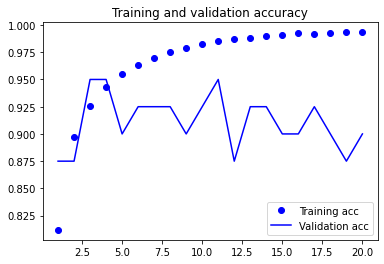

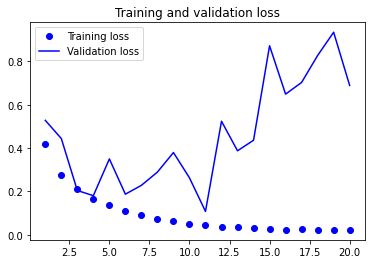

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=90)
print('test acc:', test_acc)

Found 44 images belonging to 2 classes.
test acc: 0.9090909361839294


Eğitim Yorumu:

> Eğitimimize drop-out ekleyerek deneyimizi tekrarladık. Dropout değeri genel olarak 0.5 kullanılmaktadır. Bizde bu değeri değiştirmeden kullanmayı tercih ettik. Eğitimimizdeki Train Loss veri seti veya veri seri doğrulama üzerindeki hatalardır. Grafiğimize ve acc değerimize baktığımızda önceki grafiklere göre daha iyi bir grafik ve acc değeri yakaladık. Bunun en önemli nedeni ise drop-out kullanmamızdır.

4. ADIM ERKEN EPOCH KESME DENEYİ

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # Dropout eklendi
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

Found 334 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=960,
    epochs=4, # epoch değerini erken kesmek için 4 e ayarladık.
    validation_data=validation_generator,
    validation_steps=90)

Epoch 1/4
960/960 [==============================] - 163s 170ms/step - loss: 0.4287 - acc: 0.8070 - val_loss: 0.2789 - val_acc: 0.9000
Epoch 2/4
960/960 [==============================] - 161s 168ms/step - loss: 0.2830 - acc: 0.8912 - val_loss: 0.6050 - val_acc: 0.8500
Epoch 3/4
960/960 [==============================] - 163s 170ms/step - loss: 0.2222 - acc: 0.9188 - val_loss: 0.3506 - val_acc: 0.9000
Epoch 4/4
960/960 [==============================] - 163s 170ms/step - loss: 0.1823 - acc: 0.9373 - val_loss: 0.3264 - val_acc: 0.8750


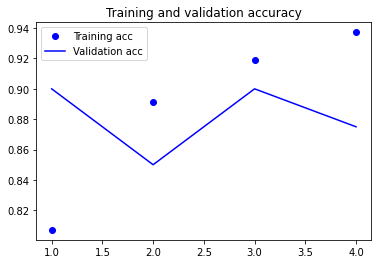

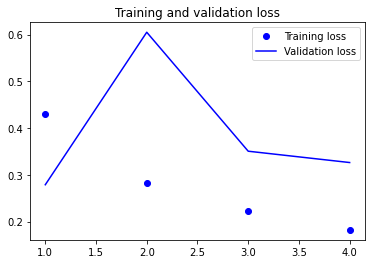

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_kısmı,
    target_size=(50, 50),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=90)
print('test acc:', test_acc)

Found 44 images belonging to 2 classes.
test acc: 0.9318181872367859


**Eğitim Yorumu:**

> Grafik sonuçlarına baktığımız zaman sonuçta büyük bir fark göremedik. Bunun nedeni ise önceki sonuçlarımızda bahsettiğimiz test veya eğitilecek olan verilerimiizin sayısının yeterli olmamasından kaynaklıdır. ACC değerimi bir önceki test sonuç acc sine göre daha düşük çıktı lakin grafiğimizde pek bir değişiklik olmadı.



**SONUÇ**

> Deep Learning modellerinde çok fazla GPU kullanımı bulunmaktadır ve güçlü bir GPU gerekirmektedir. Bizde projemizde "Runtime" menüsü altında "Change Runtime Type" başlığı altında orada bulunan seçeneklerden GPU seçeneğini seçtik. Bunun nedeni uzun süren eğitimlerimizi daha kısa sürede tamamlamak. Seçim yapmadan önce 1.Adımda gerçekleşen eğitim 110sn civarı sürerken seçtikten sorna bu değer 34sn ye kadar indi. Bu eğitimimizde veri setimizdeki veriler çok az olduğu için eğitimimizde aşırı ezberlemeye yönelik işledi. Daha güçlü bir GPUC ve daha çok verinin bulunduğu bir sistem kullanırsak doğruluğu yüksek sonuçlar elde edebiliriz. Lakin bu aldığımız sonuçlar günlük hayatta kullanılabilir bir cinsten sonuçlar değildir.

